In [3]:
from pathlib import Path
import cv2
import collections
import numpy as np
import torchvision
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
from torch.nn import functional as f
from PIL import Image
from matplotlib import pyplot as plt
import time
from moco_model import MoCo
import json

In [3]:
# rename

rename_path = Path('E:/datasets/NDI_images/Integreted/Observed')
files = rename_path.glob('*.jpg')
for file in files:
    new_name = str(file.name).split('.')
    order = new_name[0].split('_')[0]
    new_name = order + '.' + new_name[-1]
    file.rename(str(Path.joinpath(rename_path, new_name)))

In [16]:
# check channel

# observed
img_path = Path('E:/datasets/NDI_images/Integreted/Observed')
files = list(img_path.glob('*.jpg'))
shape_counter = collections.defaultdict(int)
for file in files:
    shape_counter[cv2.imread(str(file), cv2.IMREAD_UNCHANGED).shape] += 1
print('Observed Shape Counter: ', shape_counter)

# calculated
img_path = Path('E:/datasets/NDI_images/Integreted/Calculated')
files = list(img_path.glob('*.jpg'))
shape_counter = collections.defaultdict(int)
for file in files:
    shape_counter[cv2.imread(str(file), cv2.IMREAD_UNCHANGED).shape] += 1
print('Calculated Shape Counter: ', shape_counter)


Observed Shape Counter:  defaultdict(<class 'int'>, {(200, 200): 184})
Calculated Shape Counter:  defaultdict(<class 'int'>, {(200, 200, 3): 184})


In [18]:
# Grayscale

img_path = Path('E:/datasets/NDI_images/Integreted/Calculated')
grayscale_path = Path.joinpath(img_path, 'grayscale')
files = list(img_path.glob('*.jpg'))
for file in files:
    file_stem = file.name
    img = cv2.imread(str(file), cv2.IMREAD_UNCHANGED)
    cv2.imwrite(str(Path.joinpath(grayscale_path, file_stem)), cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

In [4]:
# Image paths

ORIGINAL_IMAGE = 'E:/datasets/NDI_images/Integreted/Observed'
TARGET_IMAGE = 'E:/datasets/NDI_images/Integreted/Calculated/grayscale'

In [5]:
# dataset

class NDIDatasetContrastiveLearning(Dataset):
    def __init__(self):
        super(NDIDatasetContrastiveLearning, self).__init__()
        original_images = list(Path(ORIGINAL_IMAGE).glob('*.jpg'))
        origins, targets, labels = [], [], []
        to_tensor_func = torchvision.transforms.ToTensor()
        for original_image in original_images:
            origins.append(to_tensor_func(Image.open(str(original_image))))
            targets.append(to_tensor_func(Image.open(str(Path.joinpath(Path(TARGET_IMAGE), original_image.name)))))
            labels.append(int(original_image.name.split('.')[0]) - 1)
        random_index = np.random.permutation(len(origins))
        self.origins, self.targets, self.labels = [], [], []
        for index in random_index:
            self.origins.append(origins[index])
            self.targets.append(targets[index])
            self.labels.append(labels[index])

    def __getitem__(self, idx):
        return self.origins[idx], self.targets[idx], self.labels[idx]

    def __len__(self):
        return len(self.origins)

In [4]:
model = MoCo(torchvision.models.resnet18, dim=128, K=48)
device = torch.device('cuda:0')
criterion = nn.CrossEntropyLoss().cuda(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-4)

In [5]:
# split dataset

dataset = NDIDatasetContrastiveLearning()
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [160, 24])
train_iter = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_iter = DataLoader(val_dataset, batch_size=len(val_dataset))

In [6]:
def image_pair_matching(net, original_image, matching_image):
    net.eval()
    q = net.encoder_q(original_image)
    q = f.normalize(q, dim=1)
    k = net.encoder_k(matching_image)
    k = f.normalize(k, dim=1)
    logits = torch.einsum('nc,ck->nk', [q, k.T])
    return logits

def cal_accuracy(preds, label):
    return float(torch.sum(torch.argmax(preds, dim=1).type_as(label) == label))

In [7]:
def train_moco(net, criterion, optimizer, epochs, device):
    to_tensor_func = torchvision.transforms.ToTensor()
    target_tensor = []
    for i in range(1, 185):
        target_tensor.append(to_tensor_func(Image.open(str(Path.joinpath(Path(TARGET_IMAGE), f'{i}.jpg')))).unsqueeze(0))
    target_tensor = torch.cat(target_tensor, dim=0)
    target_tensor = target_tensor.cuda(device)
    for epoch in range(epochs):
        net.cuda(device)
        total_loss = 0
        training_correct = 0
        training_size = 0
        for origin, target, label in train_iter:
            net.train()
            origin, target, label = origin.cuda(device), target.cuda(device), label.cuda(device)
            output, labels = net(origin, target)
            loss = criterion(output, labels)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            net.eval()
            training_correct += cal_accuracy(image_pair_matching(net, origin, target_tensor), label)
            training_size += origin.shape[0]
        net.eval()
        val_loss = 0
        for origin, target, label in val_iter:
            origin, target, label = origin.cuda(device), target.cuda(device), label.cuda(device)
            output, labels = net(origin, target, evaluate=True)
            val_loss += f.cross_entropy(output, labels).item()
            val_correct = cal_accuracy(image_pair_matching(net, origin, target_tensor), label)
        val_acc = val_correct / origin.shape[0]
        print(f'Epoch {epoch + 1}, Loss {total_loss / len(train_iter)}, Train_acc {training_correct / training_size}, Val_loss {val_loss / len(val_iter)}, Val_acc {val_acc}')

In [ ]:
train_moco(model, criterion, optimizer, 50, device)

In [8]:
class Accumulator:
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

class HistoryRecorder:
    def __init__(self, names):
        self.data = {name: [] for name in names}
        self.names = names

    def add(self, *args):
        for name, value in zip(self.names, args):
            self.data[name].append(value)

    def reset(self):
        self.data = {name: [] for name in self.names}

    def __getitem__(self, name):
        return self.data[name]

def train_moco_return_metrics(net, criterion, optimizer, epochs, device):
    train_metrics = HistoryRecorder(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'])
    to_tensor_func = torchvision.transforms.ToTensor()
    target_tensor = []
    for i in range(1, 185):
        target_tensor.append(to_tensor_func(Image.open(str(Path.joinpath(Path(TARGET_IMAGE), f'{i}.jpg')))).unsqueeze(0))
    target_tensor = torch.cat(target_tensor, dim=0)
    target_tensor = target_tensor.cuda(device)
    for epoch in range(epochs):
        net.cuda(device)
        total_loss = 0
        training_correct = 0
        training_size = 0
        for origin, target, label in train_iter:
            net.train()
            origin, target, label = origin.cuda(device), target.cuda(device), label.cuda(device)
            output, labels = net(origin, target)
            loss = criterion(output, labels)
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            net.eval()
            training_correct += cal_accuracy(image_pair_matching(net, origin, target_tensor), label)
            training_size += origin.shape[0]
        net.eval()
        val_loss = 0
        for origin, target, label in val_iter:
            origin, target, label = origin.cuda(device), target.cuda(device), label.cuda(device)
            output, labels = net(origin, target, evaluate=True)
            val_loss += f.cross_entropy(output, labels).item()
            val_correct = cal_accuracy(image_pair_matching(net, origin, target_tensor), label)
        val_acc = val_correct / origin.shape[0]
        train_metrics.add(total_loss / len(train_iter), training_correct / training_size, val_loss / len(val_iter), val_acc)
        print(f'Epoch {epoch + 1}, Loss {total_loss / len(train_iter)}, Train_acc {training_correct / training_size}, Val_loss {val_loss / len(val_iter)}, Val_acc {val_acc}')
    return train_metrics

Epoch 1, Loss 3.4506182260527565, Train_acc 0.00625, Val_loss 3.952214479446411, Val_acc 0.0
Epoch 2, Loss 3.8356375217437746, Train_acc 0.0125, Val_loss 3.8774967193603516, Val_acc 0.0
Epoch 3, Loss 3.7355607986450194, Train_acc 0.0, Val_loss 3.5797455310821533, Val_acc 0.0
Epoch 4, Loss 3.496684956550598, Train_acc 0.00625, Val_loss 2.85373592376709, Val_acc 0.0
Epoch 5, Loss 3.3075857639312742, Train_acc 0.0125, Val_loss 3.528470754623413, Val_acc 0.0
Epoch 6, Loss 3.061128258705139, Train_acc 0.025, Val_loss 3.5345284938812256, Val_acc 0.0
Epoch 7, Loss 3.2853986263275146, Train_acc 0.03125, Val_loss 4.697645664215088, Val_acc 0.0
Epoch 8, Loss 3.117504692077637, Train_acc 0.0375, Val_loss 5.1814727783203125, Val_acc 0.041666666666666664
Epoch 9, Loss 3.075301003456116, Train_acc 0.01875, Val_loss 5.032065391540527, Val_acc 0.0
Epoch 10, Loss 3.1071490049362183, Train_acc 0.025, Val_loss 4.020771503448486, Val_acc 0.0
Epoch 11, Loss 3.0891750335693358, Train_acc 0.025, Val_loss 4.2

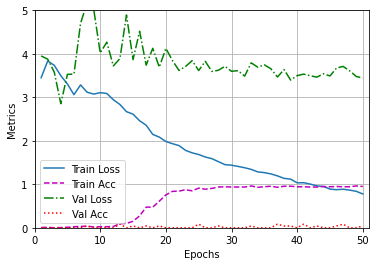

In [21]:
start_time = time.time()
metrics = train_moco_return_metrics(model, criterion, optimizer, 50, device)
end_time = time.time()
print(f'Take {end_time - start_time:.2f} secs for training {50} epochs')
fmts = ('-', 'm--', 'g-.', 'r:')
X = [np.arange(1, 51, 1) for _ in range(4)]
for x, y, fmt in zip(X, metrics.names, fmts):
    plt.plot(x, metrics.data[y], fmt)
ax = plt.gca()
ax.set_xlabel('Epochs')
ax.set_ylabel('Metrics')
ax.set_xlim([0, 51])
ax.set_ylim([0, 5])
ax.legend(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'])
ax.grid()
plt.show()

Epoch 1, Loss 2.5860689885175816, Train_acc 0.00625, Val_loss 2.3841750621795654, Val_acc 0.0
Epoch 2, Loss 2.773030424118042, Train_acc 0.00625, Val_loss 3.0412845611572266, Val_acc 0.0
Epoch 3, Loss 2.594136118888855, Train_acc 0.0125, Val_loss 1.9403139352798462, Val_acc 0.0
Epoch 4, Loss 2.2726661920547486, Train_acc 0.0, Val_loss 0.9704110026359558, Val_acc 0.0
Epoch 5, Loss 2.1506732225418093, Train_acc 0.0125, Val_loss 1.483282446861267, Val_acc 0.0
Epoch 6, Loss 2.17998605966568, Train_acc 0.00625, Val_loss 2.808746576309204, Val_acc 0.0
Epoch 7, Loss 2.22318776845932, Train_acc 0.0125, Val_loss 2.7702348232269287, Val_acc 0.041666666666666664
Epoch 8, Loss 2.081069231033325, Train_acc 0.03125, Val_loss 2.660992383956909, Val_acc 0.0
Epoch 9, Loss 1.9817218422889709, Train_acc 0.05625, Val_loss 2.554062604904175, Val_acc 0.0
Epoch 10, Loss 1.874521017074585, Train_acc 0.075, Val_loss 3.085033416748047, Val_acc 0.0
Epoch 11, Loss 1.630536150932312, Train_acc 0.1625, Val_loss 2.3

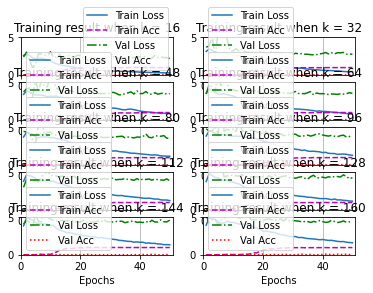

In [11]:
metrics = {}
k_values = [16, 32, 48, 64, 80, 96, 112, 128, 144, 160]
fmts = ('-', 'm--', 'g-.', 'r:')
X = [np.arange(1, 51, 1) for _ in range(4)]
fig, axes = plt.subplots(5, 2)
axes = axes.flatten()
dataset = NDIDatasetContrastiveLearning()
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [160, 24])
train_iter = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
val_iter = DataLoader(val_dataset, batch_size=len(val_dataset))
for k, ax in zip(k_values, axes):
    model = MoCo(torchvision.models.resnet18, dim=128, K=k)
    device = torch.device('cuda:0')
    criterion = nn.CrossEntropyLoss().cuda(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=1e-4)
    start_time = time.time()
    sub_metrics = train_moco_return_metrics(model, criterion, optimizer, 50, device)
    end_time = time.time()
    metrics[k] = sub_metrics.data
    metrics[k]['Training time'] = round(end_time - start_time, 2)
    for x, y, fmt in zip(X, sub_metrics.names, fmts):
        ax.plot(x, sub_metrics.data[y], fmt)
    ax.set_xlabel('Epochs')
    ax.set_xlim([0, 51])
    ax.set_ylim([0, 5])
    ax.legend(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'])
    ax.grid()
    ax.set_title(f'Training result when k = {k}')
plt.show()

In [12]:
with open('different_k_result.json', 'w', encoding='utf-8') as f:
        json.dump(metrics, f)

In [13]:
with open('different_k_result.json', 'r', encoding='utf-8') as f:
    a = json.load(f)
a.keys()

dict_keys(['16', '32', '48', '64', '80', '96', '112', '128', '144', '160'])

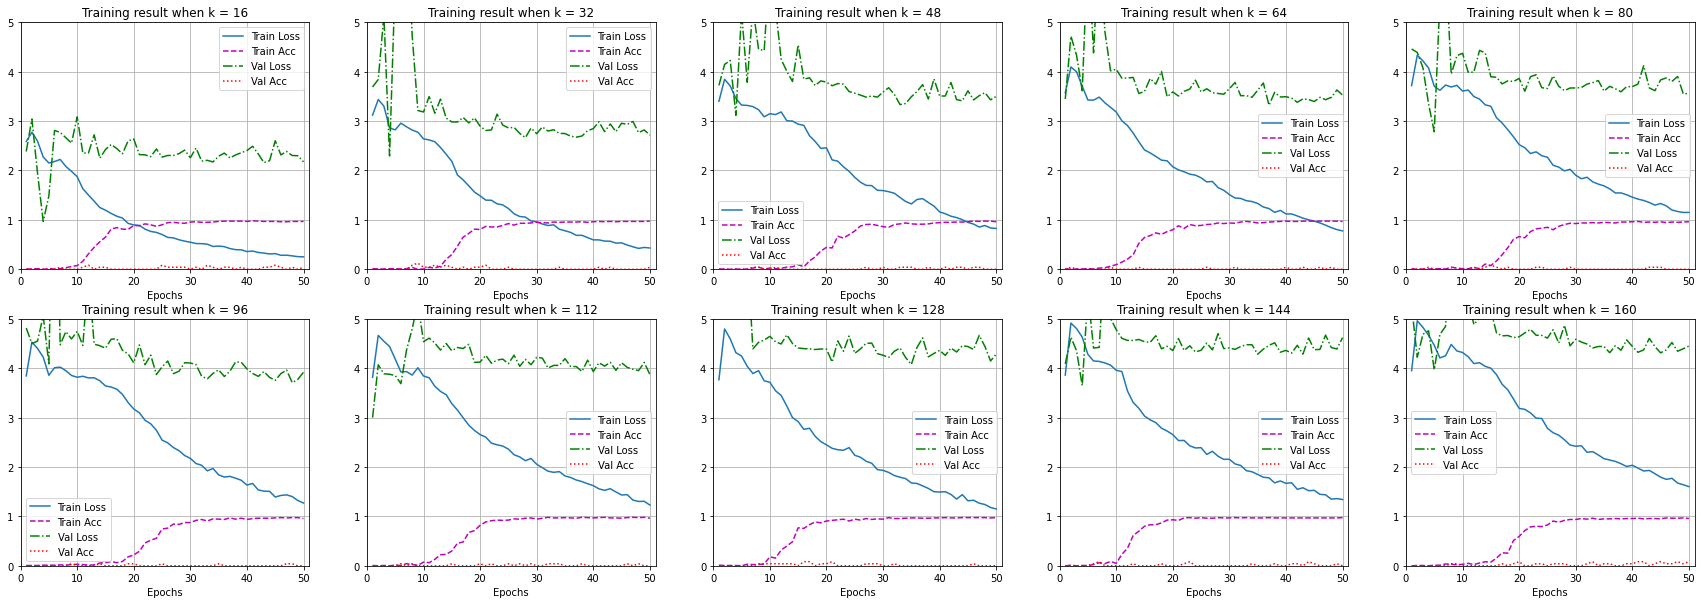

In [14]:
fig, axes = plt.subplots(2, 5, figsize=(30, 10))
axes = axes.flatten()
X = [np.arange(1, 51, 1) for _ in range(4)]
fmts = ('-', 'm--', 'g-.', 'r:')
names = ['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc']
for k, ax in zip(a.keys(), axes):
    for x, y, fmt in zip(X, names, fmts):
        ax.plot(x, a[k][y], fmt)
    ax.set_xlabel('Epochs')
    ax.set_xlim([0, 51])
    ax.set_ylim([0, 5])
    ax.legend(['Train Loss', 'Train Acc', 'Val Loss', 'Val Acc'])
    ax.grid()
    ax.set_title(f'Training result when k = {k}')
plt.show()